In [109]:
from pathlib import Path
import sys

BASE_PATH = Path('../')
PATH_TO_DATA = BASE_PATH/'data'
PATH_TO_MODELS = BASE_PATH/'checkpoints'
PATH_TO_CACHE = BASE_PATH/'cache'
PATH_TO_LOGS = BASE_PATH/'logs'

PATH_TO_CACHE.mkdir(exist_ok=True, parents=True)
PATH_TO_DATA.mkdir(exist_ok=True, parents=True)
PATH_TO_MODELS.mkdir(exist_ok=True, parents=True)
PATH_TO_LOGS.mkdir(exist_ok=True, parents=True)


sys.path.append(str(BASE_PATH/'..'))

#### <b>Load Libraries</b>

In [2]:
import pprint
from copy import deepcopy
from tqdm import tqdm
import time
import random
from pathlib import Path
import pickle

from PIL import Image

import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import models
from torchvision import transforms
from torchvision.datasets import CIFAR10

from torch.utils.data import Dataset, DataLoader, Subset

from utils import progress_bar, load_model

stty: 'standard input': Inappropriate ioctl for device


#### <b>Notebook Constants</b>

In [3]:
RANDOM_STATE = 42
BATCH_SIZE = 256
NUM_WORKERS = 4
DEVICE = 'cuda'
NUM_CLASSES = 10

In [4]:
def set_random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

#### <b>Define Custom Dataset</b>

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_aug = CIFAR10(root=PATH_TO_DATA, train=True, transform=train_transforms)
cifar10 = CIFAR10(root=PATH_TO_DATA, train=True, transform=test_transforms)

test_dataset = CIFAR10(root=PATH_TO_DATA, train=False, transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [6]:
train_inds = np.load(PATH_TO_DATA/'train_inds.npy')
unseen_inds = np.load(PATH_TO_DATA/'unseen_inds.npy')
retain_inds = np.load(PATH_TO_DATA/'retain_inds.npy')
forget_inds = np.load(PATH_TO_DATA/'forget_inds.npy')
shadow_inds = np.load(PATH_TO_DATA/'shadow_inds.npy')


with open(PATH_TO_DATA/'data_split.pickle', 'rb') as file:
    data_split = pickle.load(file)

#### <b>Evalution utils</b>

In [7]:
def downstream_task_performance(model, dataloader):
    model.eval()
    top2_correct = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)

            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)
            top2_correct += top2_preds.eq(targets.view(-1, 1).expand_as(top2_preds)).any(dim=1).sum().item()

            progress_bar(batch_idx, len(dataloader), f'Acc: {100*correct/total:.2f}%%% Top2 Acc: {100*top2_correct/total:.2f}%%%')
    
    return 100*correct/total, 100*top2_correct/total

In [8]:
from MIA.score import get_logits, lira_offline, lira_online

def lira(target_net, train_inds, forget_inds, data_split, cached=True):

    num_aug = 1
    fix_variance = False

    if num_aug > 1:
        dataset = Subset(cifar10_aug, train_inds)
    else:
        dataset = Subset(cifar10, train_inds)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    labels = np.int64(~np.isin(train_inds, forget_inds))
    masks_in = [np.array(data_split[x]) for x in train_inds]
    
    if cached and (PATH_TO_CACHE/'shadow_logits.npy').is_file():
        shadow_logits = np.load(PATH_TO_CACHE/'shadow_logits.npy')
        print('Shadow logits were brought from cache')
    else:
        shadow_nets = [load_model(state_dict, NUM_CLASSES).to(DEVICE) for state_dict in (PATH_TO_MODELS/'shadow').glob('*/*')]
        shadow_logits = []
        for _ in range(num_aug):
            dataset_labels = []
            shadow_aug_logits = [[] for _ in range(len(shadow_nets))]
            with torch.no_grad():
                for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
                    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                    for i, net in enumerate(shadow_nets):
                        logits = net(inputs).cpu().tolist()
                        shadow_aug_logits[i].append(logits)
                
                    dataset_labels.append(targets.cpu().tolist())

            shadow_aug_logits = np.stack([np.concatenate(logits) for logits in shadow_aug_logits])  # [n_shadow, n_examples, n_classes]
            dataset_labels = np.concatenate(dataset_labels)[:, None]  # [n_examples, 1]

            # Extract numerically stable logits
            shadow_aug_logits = get_logits(shadow_aug_logits, np.repeat(dataset_labels[None], len(shadow_nets), 0))
            shadow_logits.append(shadow_aug_logits)
        
        shadow_logits = np.stack(shadow_logits, axis=-1)
        shadow_logits = np.swapaxes(shadow_logits, 0, 1)  # [n_examples, n_shadow, n_aug]
        np.save(PATH_TO_CACHE/'shadow_logits.npy', shadow_logits)
    
    target_logits = []
    for _ in range(num_aug):
        dataset_labels = []
        target_aug_logits = []
        with torch.no_grad():
            for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                logits = target_net(inputs).cpu().tolist()
                target_aug_logits.append(logits)
        
                dataset_labels.append(targets.cpu().tolist())
            
        
        target_aug_logits = np.concatenate(target_aug_logits)  # [n_examples, n_classes]
        dataset_labels = np.concatenate(dataset_labels)[:, None]  # [n_examples, 1]

        # Extract numerically stable logits
        target_aug_logits = get_logits(target_aug_logits, dataset_labels)

        target_logits.append(target_aug_logits)

    target_logits = np.stack(target_logits, axis=-1)  # [n_examples, n_aug]

    fnr, tnr, auc, low = lira_online(target_logits, shadow_logits, labels, masks_in, fix_variance=fix_variance)

    return fnr, tnr, auc, low

In [9]:
def evaluate_unlearning(model, forget_inds, retain_inds):

    global cifar10, train_inds, data_split, unseen_inds, test_dataloader

    unseen_dataset = Subset(cifar10, unseen_inds)
    unseen_dataloader = DataLoader(unseen_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    forget_dataset = Subset(cifar10, forget_inds)
    forget_dataloader = DataLoader(forget_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    retain_dataset = Subset(cifar10, retain_inds)
    retain_dataloader = DataLoader(retain_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    model.eval()
    
    retain_acc = downstream_task_performance(model, retain_dataloader)
    forget_acc = downstream_task_performance(model, forget_dataloader)
    test_acc = downstream_task_performance(model, test_dataloader)
    unseen_acc = downstream_task_performance(model, test_dataloader)
    fnr, tnr, auc, low = lira(model, train_inds, forget_inds, data_split)

    result_df = pd.DataFrame(
            index=[
                'retain_acc',
                'forget_acc',
                'test_acc',
                'unseen_acc',
                'MIA_AUC','MIA_TNR@1%FNR'
            ],
            data=[
                np.round(retain_acc[0], 2),
                np.round(forget_acc[0], 2),
                np.round(test_acc[0], 2),
                np.round(unseen_acc[0], 2),
                np.round(100*auc, 2),
                np.round(100*low, 2)
            ]
            ).T

    return result_df, fnr, tnr


#### <b>Evaluate origin model</b>

 [=======================================>]  Step: 3ms | Tot: 643ms | Acc: 89.05%%% Top2 Acc: 96.75% 84/84  
 [================================>.......]  Step: 3ms | Tot: 25ms | Acc: 89.16%%% Top2 Acc: 96.80% 5/5  
 [=======================================>]  Step: 3ms | Tot: 309ms | Acc: 75.21%%% Top2 Acc: 88.86% 40/40  
 [=======================================>]  Step: 2ms | Tot: 280ms | Acc: 75.21%%% Top2 Acc: 88.86% 40/40  
Shadow logits were brought from cache


100%|██████████| 88/88 [00:00<00:00, 89.66it/s] 


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR
0,89.05,89.16,75.21,75.21,49.84,1.07


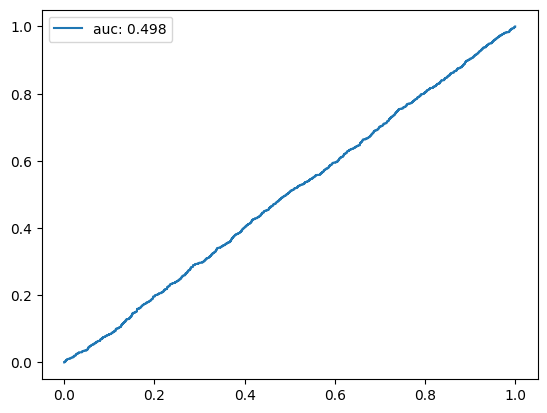

In [67]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
 
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

#### <b>Evaluate retrained model</b>

 [=======================================>]  Step: 3ms | Tot: 628ms | Acc: 90.18%%% Top2 Acc: 97.01% 84/84   ===============>........................]  Step: 19ms | Tot: 250ms | Acc: 89.77%%% Top2 Acc: 96.71% 33/84 
 [================================>.......]  Step: 3ms | Tot: 35ms | Acc: 74.93%%% Top2 Acc: 89.69% 5/5  
 [=======================================>]  Step: 3ms | Tot: 334ms | Acc: 75.93%%% Top2 Acc: 89.24% 40/40  
 [=======================================>]  Step: 2ms | Tot: 284ms | Acc: 75.93%%% Top2 Acc: 89.24% 40/40  
Shadow logits were brought from cache


100%|██████████| 88/88 [00:00<00:00, 110.16it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR
0,90.18,74.93,75.93,75.93,68.88,9.6


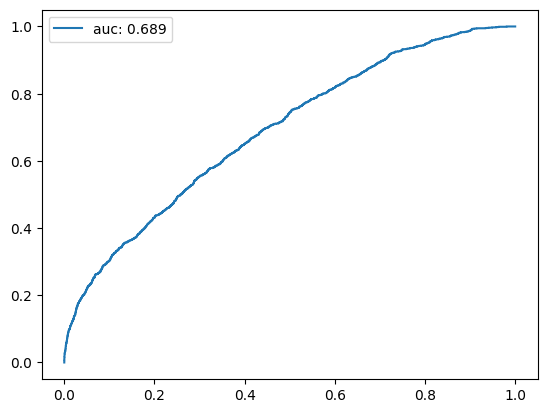

In [68]:
model = load_model(PATH_TO_MODELS/'retrained'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
 
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

#### <b>Unlearning</b>

##### <b>Fine Tuning</b>

In [72]:
def fine_tune_unlearning(model, forget_inds, retain_inds, unseen_inds):

    set_random_seed(RANDOM_STATE)
    
    model.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    dataset = Subset(cifar10_aug, retain_inds)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, targets in tqdm(dataloader, desc=f'epoch {epoch}/{num_epochs}', leave=False):
            
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

 [=======================================>]  Step: 3ms | Tot: 611ms | Acc: 89.41%%% Top2 Acc: 96.93% 84/84  ===============>........................]  Step: 16ms | Tot: 238ms | Acc: 89.58%%% Top2 Acc: 97.04% 33/84 
 [================================>.......]  Step: 4ms | Tot: 16ms | Acc: 88.80%%% Top2 Acc: 96.53% 5/5  
 [=======================================>]  Step: 3ms | Tot: 286ms | Acc: 75.19%%% Top2 Acc: 88.81% 40/40  
 [=======================================>]  Step: 3ms | Tot: 298ms | Acc: 75.19%%% Top2 Acc: 88.81% 40/40  
Shadow logits were brought from cache


100%|██████████| 88/88 [00:01<00:00, 86.84it/s] 


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR,unlearning_time
0,89.41,88.8,75.19,75.19,50.95,1.42,14


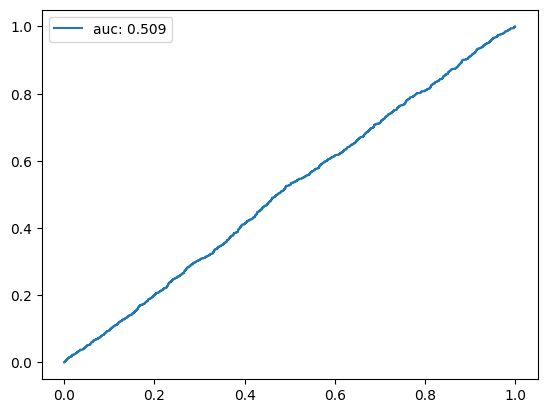

In [74]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
fine_tune_unlearning(model, forget_inds, retain_inds, unseen_inds)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

##### <b>UnGAN</b>

In [122]:
hidden_size=128

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.class_embeddings = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(2*num_classes, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        
    def forward(self, logits, label):
        label_emb = self.class_embeddings(label)
        z = torch.hstack([logits, label_emb])
        return self.model(z).flatten()

class Trainer:
    def __init__(self, model):
        
        self.discriminator = Discriminator(NUM_CLASSES)
        self.model = model
        self.alpha = 0.1

        self.model.cuda()
        self.discriminator.cuda()
        
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, weight_decay=1e-5)
        self.d_criterion = nn.BCEWithLogitsLoss()

        self.g_optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-5, weight_decay=1e-5)
        self.g_criterion = nn.CrossEntropyLoss(reduction='mean')
        

    def generator_step(self, forget_logits, forget_labels, retain_logits, retain_labels):
        
        ones = torch.ones(forget_logits.size(0)).cuda()
        forget_preds = self.discriminator(forget_logits, forget_labels)
        d_loss = self.d_criterion(forget_preds, ones)
        
        g_loss = self.g_criterion(retain_logits, retain_labels)

        loss = d_loss + self.alpha * g_loss

        self.g_optimizer.zero_grad()
        loss.backward()
        self.g_optimizer.step()

        return loss.item()
        
    def discriminator_step(self, forget_logits, forget_labels, unseen_logits, unseen_labels):
        
        ones = torch.ones(unseen_logits.size(0)).cuda()
        zeros = torch.zeros(forget_logits.size(0)).cuda()
    
        forget_preds = self.discriminator(forget_logits, forget_labels)
        unseen_preds = self.discriminator(unseen_logits, unseen_labels)
    
        loss = self.d_criterion(forget_preds, zeros) + self.d_criterion(unseen_preds, ones)
        self.d_optimizer.zero_grad()
        loss.backward()
        self.d_optimizer.step()

        return loss.item()
        
        
def ungan_unlearning(model, forget_manifest, retain_manifest, unseen_manifest):

    trash_path = Path('trash.txt')
    loss_path = Path('gan_loss.txt')
    metrics_path = Path('gan_metrics.txt')
    loss_path.write_text('step,D_loss,G_loss\n')
    metrics_path.write_text('step,forget_JS,valid_JS,forget_accuracy,valid_accuracy,retain_accuracy\n')
    trash_path.write_text('n,d_loss')
    
    dataset = Subset(cifar10, forget_inds)
    forget = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    dataset = Subset(cifar10_aug, retain_inds)
    retain = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    dataset = Subset(cifar10, unseen_inds)
    unseen = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)


    trainer = Trainer(model)
    step = 0
    epochs = 30
    num_discriminator_steps = 10
    num_generator_steps = 1
    discriminator_pretraining_steps = 200

    trainer.model.eval()
            
    unseen_logits_all, unseen_labels_all = [], []
    with torch.no_grad():
        for u in tqdm(unseen, desc='score unseen', leave=False):
            unseen_logits_all.append(trainer.model(u[0].to(DEVICE)))
            unseen_labels_all.append(u[1].to(DEVICE))
    unseen_logits_all = torch.cat(unseen_logits_all)
    unseen_labels_all = torch.cat(unseen_labels_all)
        
    forget_logits_all, forget_labels_all = [], []
    with torch.no_grad():
        for f in tqdm(forget, desc='score forget', leave=False):
            forget_logits_all.append(trainer.model(f[0].to(DEVICE)))
            forget_labels_all.append(f[1].to(DEVICE))
    forget_logits_all = torch.cat(forget_logits_all)
    forget_labels_all = torch.cat(forget_labels_all)

    valid_scores = score_model(trainer.model, unseen, progress=False)
    forget_scores = score_model(trainer.model, forget, progress=False)
    retain_scores = score_model(trainer.model, retain, progress=False)
    print(accuracy_score(valid_scores.labels, valid_scores.preds), JS_divergence_single(
                valid_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
                forget_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
                plot=False), accuracy_score(retain_scores.labels, retain_scores.preds), accuracy_score(forget_scores.labels, forget_scores.preds))

                
    # discriminator pretraining
    for n in range(discriminator_pretraining_steps):

        inds = np.random.choice(len(forget_labels_all), size=BATCH_SIZE, replace=False)
        forget_logits, forget_labels = forget_logits_all[inds], forget_labels_all[inds]
                    
        inds = np.random.choice(len(unseen_logits_all), size=BATCH_SIZE, replace=False)
        unseen_logits, unseen_labels = unseen_logits_all[inds], unseen_labels_all[inds]
            
        d_loss = trainer.discriminator_step(forget_logits, forget_labels, unseen_logits, unseen_labels)

        with open(trash_path, 'a') as file:
            print(n, d_loss, file=file)

                        
    for epoch in tqdm(range(epochs)):
        
        # discriminator step
        trainer.model.eval()
        # n = 0
        average_loss = 100
        for n in range(num_discriminator_steps):
            for forget_batch in forget:
            
                with torch.no_grad():
                    forget_logits, forget_labels = trainer.model(forget_batch[0].to(DEVICE)), forget_batch[1].to(DEVICE)

                inds = np.random.choice(len(unseen_logits_all), size=BATCH_SIZE, replace=False)
                unseen_logits, unseen_labels = unseen_logits_all[inds], unseen_labels_all[inds]

                d_loss = trainer.discriminator_step(forget_logits, forget_labels, unseen_logits, unseen_labels)
                average_loss = d_loss if average_loss == 100 else 0.5 * average_loss + 0.5 * d_loss
                
            
            #     n += 1
            
            # if n >= n_range:
            #     break

        n_range = min(n_range//2, 1) if average_loss < 1.0 else 25

        # generator step
        for n in range(num_generator_steps):
            for (forget_batch, retain_batch) in zip(forget, retain):
                
                step+= 1
            
                trainer.model.train()
                retain_features, retain_labels = retain_batch[0].cuda(), retain_batch[1].cuda()
                retain_logits = trainer.model(retain_features)
                
                trainer.model.eval()
                forget_features, forget_labels = forget_batch[0].cuda(), forget_batch[1].cuda()
                forget_logits = trainer.model(forget_features)

                g_loss = trainer.generator_step(forget_logits, forget_labels, retain_logits, retain_labels)
                
                # with torch.no_grad():
                #     # inds = np.random.choice(len(unseen_logits_all), size=BATCH_SIZE, replace=False)
                #     # unseen_logits, unseen_labels = unseen_logits_all[inds], unseen_labels_all[inds]

                #     # ones = torch.ones(unseen_logits.size(0)).cuda()
                #     # zeros = torch.zeros(forget_logits.size(0)).cuda()
                
                #     # forget_preds = trainer.discriminator(forget_logits, forget_labels)
                #     # unseen_preds = trainer.discriminator(unseen_logits, unseen_labels)
                
                #     # d_loss = trainer.d_criterion(forget_preds, zeros) + trainer.d_criterion(unseen_preds, ones)

                #     print(average_loss)
        
                #     average_loss = g_loss if average_loss == 100 else 0.5 * average_loss + 0.5 * g_loss


        with open(loss_path, 'a') as file:
            print(step, d_loss, g_loss, file=file, sep=',')
        fs = score_model(trainer.model, forget, progress=False)
        vs = score_model(trainer.model, unseen, progress=False)
        rs = score_model(trainer.model, retain, progress=False)

        f_js = JS_divergence_single(
            fs.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
            valid_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
            plot=False)
        v_js = JS_divergence_single(
            vs.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
            valid_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
            plot=False)
        af = accuracy_score(fs.labels, fs.preds)
        av = accuracy_score(vs.labels, vs.preds)
        ar = accuracy_score(rs.labels, rs.preds)

    
        with open(metrics_path, 'a') as file:
            print(step, f_js, v_js, af, av, ar, file=file, sep=',')



    trainer.model.eval()

In [123]:
from scipy.stats import gaussian_kde
from sklearn.metrics import accuracy_score

def JS_divergence_single(ksi, psi, plot=False):
    p, q = gaussian_kde(ksi), gaussian_kde(psi)
    x = np.linspace(min(min(ksi), min(psi)), max(max(ksi), max(psi)))
    js = 0.5*np.sum(q(x) * np.log(q(x) / p(x))) + 0.5*np.sum(p(x) * np.log(p(x) / q(x)))
    if plot:
        fig, axs = plt.subplots(1, 1, figsize=(4, 3))
        axs.hist(ksi, bins=101, density=True, color='C0', alpha=0.75)
        axs.hist(psi, bins=101, density=True, color='C1', alpha=0.75)
        axs.plot(x, p(x), color='C4', lw=3)
        axs.plot(x, q(x), color='C3', lw=3)
        axs.set_title(f'KL={js:.3f}')
    return js

def score_model(model, dataloader, progress=True):
    model.eval()
    model.to(DEVICE)
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    
    all_labels = []
    all_output = []
    all_loss = []

    with torch.no_grad():
        for features, labels in tqdm(dataloader, leave=False, disable=not progress):
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            output = model(features)
            loss = loss_fn(output, labels)

            all_labels.append(labels)
            all_output.append(output)
            all_loss.append(loss)

        all_labels = torch.cat(all_labels)
        all_output = torch.cat(all_output)
        all_loss = torch.cat(all_loss)
        

        result_dict = dict()
        result_dict['labels'] = all_labels.detach().cpu().flatten().numpy()
        result_dict['preds'] = all_output.argmax(1).detach().cpu().flatten().numpy()
        result_dict['logits'] = all_output.detach().cpu().numpy().tolist()
        result_dict['loss'] = all_loss.detach().cpu().numpy().tolist()
        

    df = pd.DataFrame(result_dict)
    
    return df


def JS_divergence(logits1, logits2, plot=False):
    n_classes = logits1.shape[1]
    js = np.zeros(n_classes)
    I, J = n_classes // 3 + n_classes % 3, 3
    if plot:
        fig, axs = plt.subplots(I, J, figsize=(20, 16))
    for i in range(n_classes):
        ksi, psi = logits1[:, i], logits2[:, i]
        p, q = gaussian_kde(ksi), gaussian_kde(psi)
        x = np.linspace(min(min(ksi), min(psi)), max(max(ksi), max(psi)))
        js[i] = 0.5*np.sum(q(x) * np.log(q(x) / p(x))) + 0.5*np.sum(p(x) * np.log(p(x) / q(x)))
        if plot:
            m, n = i // J, i % J
            axs[m, n].hist(ksi, bins=101, density=True, color='C0', alpha=0.75)
            axs[m, n].hist(psi, bins=101, density=True, color='C1', alpha=0.75)
            axs[m, n].plot(x, p(x), color='C4', lw=3)
            axs[m, n].plot(x, q(x), color='C3', lw=3)
            axs[m, n].set_title(f'class {i} KL={js[i]:.3f}')
    return js.mean() 

0.757 0.3265424932486575 0.8587602339181286 0.8915555555555555


100%|██████████| 30/30 [02:14<00:00,  4.48s/it]


 [=======================================>]  Step: 3ms | Tot: 612ms | Acc: 84.35%%% Top2 Acc: 94.62% 84/84  ========================>...............]  Step: 20ms | Tot: 391ms | Acc: 84.49%%% Top2 Acc: 94.86% 53/84 
 [================================>.......]  Step: 4ms | Tot: 16ms | Acc: 83.02%%% Top2 Acc: 94.84% 5/5  
 [=======================================>]  Step: 3ms | Tot: 279ms | Acc: 72.34%%% Top2 Acc: 87.06% 40/40  
 [=======================================>]  Step: 2ms | Tot: 278ms | Acc: 72.34%%% Top2 Acc: 87.06% 40/40  
Shadow logits were brought from cache


100%|██████████| 88/88 [00:00<00:00, 113.64it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR,unlearning_time
0,84.35,83.02,72.34,72.34,51.31,1.33,137


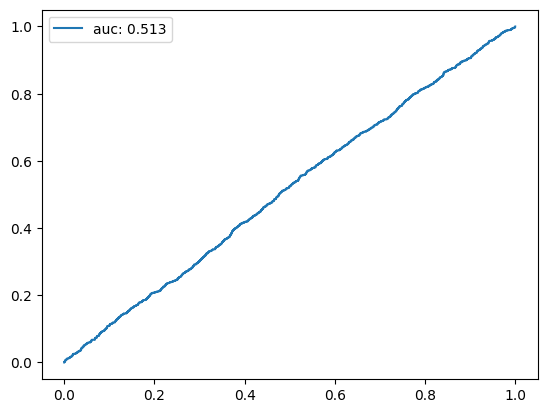

In [124]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
ungan_unlearning(model, forget_inds, retain_inds, unseen_inds)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

In [28]:
dataset = Subset(cifar10, forget_inds)
forget = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

dataset = Subset(cifar10_aug, retain_inds)
retain = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

dataset = Subset(cifar10, unseen_inds)
unseen = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

In [29]:
retain_scores = score_model(model, retain)
forget_scores = score_model(model, forget)
unseen_scores = score_model(model, unseen)



In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [32]:
df = pd.DataFrame(np.array(forget_scores.logits.tolist() + unseen_scores.logits.tolist()), columns=[str(x) for x in range(10)])
df['labels'] = forget_scores.labels.tolist() + unseen_scores.labels.tolist()
df['target'] = [0] * len(forget_scores) + [1] * len(unseen_scores)
df

,0,1,2,3,4,5,6,7,8,9,labels,target
0,1.778678,21.213648,-6.123013,-10.371286,-7.302975,-7.193273,-1.661269,-10.856470,5.826099,15.918217,1,0
1,-1.082229,1.734090,-1.113097,4.871691,-0.332948,3.573146,3.112437,-2.623995,-7.247511,0.191037,3,0
2,-0.669866,-2.142057,-1.188408,5.499761,0.067887,1.518158,-1.021725,0.546523,0.175435,-1.795005,3,0
3,-1.073117,6.925602,-2.537274,-1.012237,-4.884922,0.935785,-5.098217,-4.338870,1.548978,10.566886,9,0
4,-2.488823,-1.794526,-0.165621,6.505131,-0.100320,4.893181,2.197346,-1.275060,-5.179873,-1.612107,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6120,-1.339935,-2.791850,1.973022,0.894321,-3.007366,3.393099,-1.737300,9.741336,-5.106777,-1.857972,7,1
6121,5.895123,9.339957,-2.559609,-5.530838,-3.995441,-3.973835,-9.329264,-6.236341,1.439186,16.034456,9,1
6122,6.102581,2.544262,-0.642641,0.304411,-3.004878,-2.957581,-1.824136,-4.765697,0.235473,4.810066,0,1
6123,-1.066984,-11.910069,4.012679,4.090196,9.561313,6.024701,-1.080264,6.380686,-7.385894,-8.619872,5,1


In [33]:
m = GradientBoostingClassifier(max_depth=3, n_estimators=20)

m.fit(df[df.columns[:-1]], df['target'])

GradientBoostingClassifier(n_estimators=20)

In [34]:
metrics.roc_auc_score(df['target'], m.predict_proba(df[df.columns[:-1]])[:, 1])

0.6473386666666666

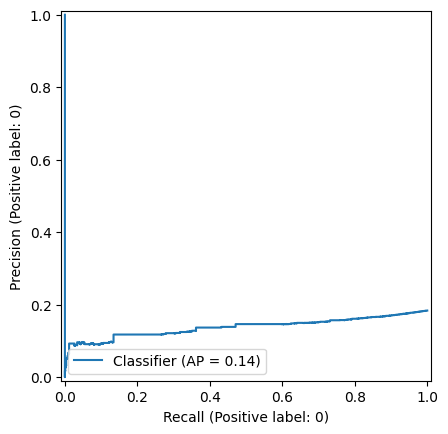

In [35]:
metrics.PrecisionRecallDisplay.from_predictions(df['target'], m.predict_proba(df[df.columns[:-1]])[:, 1], pos_label=0)

0.07658617684767603

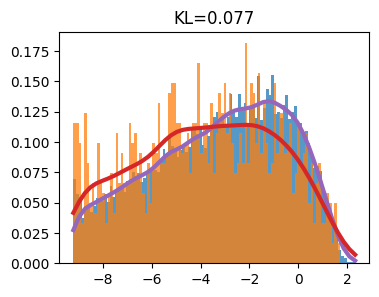

In [36]:
JS_divergence_single(retain_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), forget_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), plot=True)

0.2908704199349309

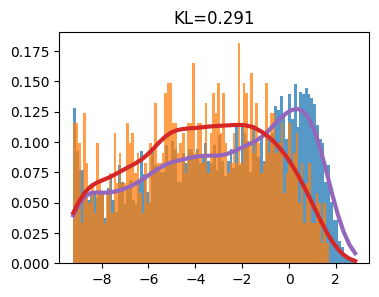

In [37]:
JS_divergence_single(unseen_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), forget_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), plot=True)

0.300367934127863

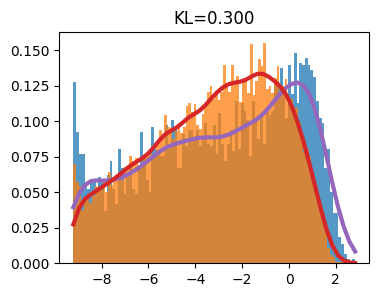

In [38]:
JS_divergence_single(unseen_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), retain_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), plot=True)

0.09044265084717111

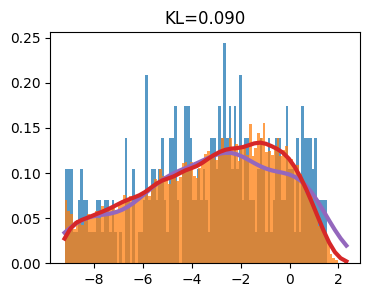

In [39]:
JS_divergence_single(retain_scores.loss.sample(270).apply(lambda x: np.log(x+1e-4)).tolist(), retain_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), plot=True)

0.03801402955039451

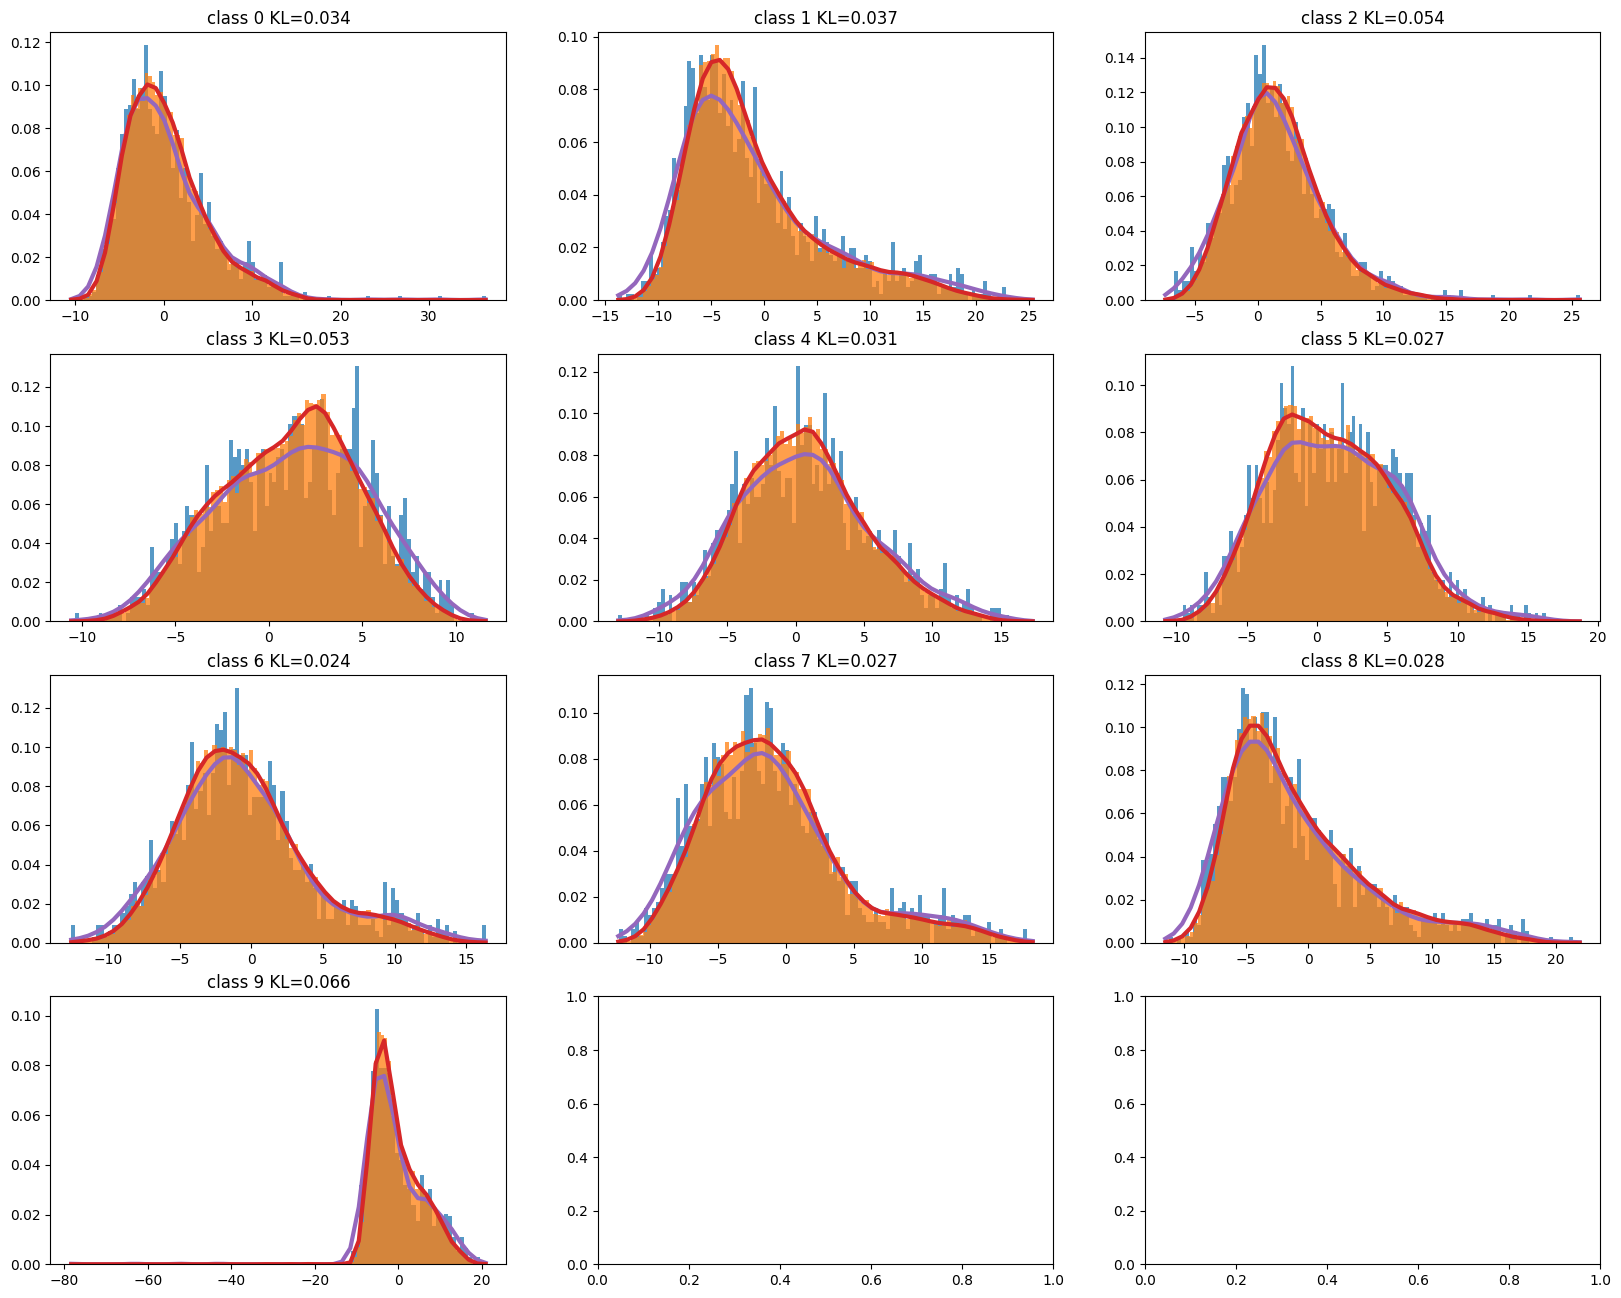

In [42]:
JS_divergence(np.array(forget_scores.logits.tolist()), np.array(retain_scores.logits.tolist()), plot=True)

0.01904217210584717

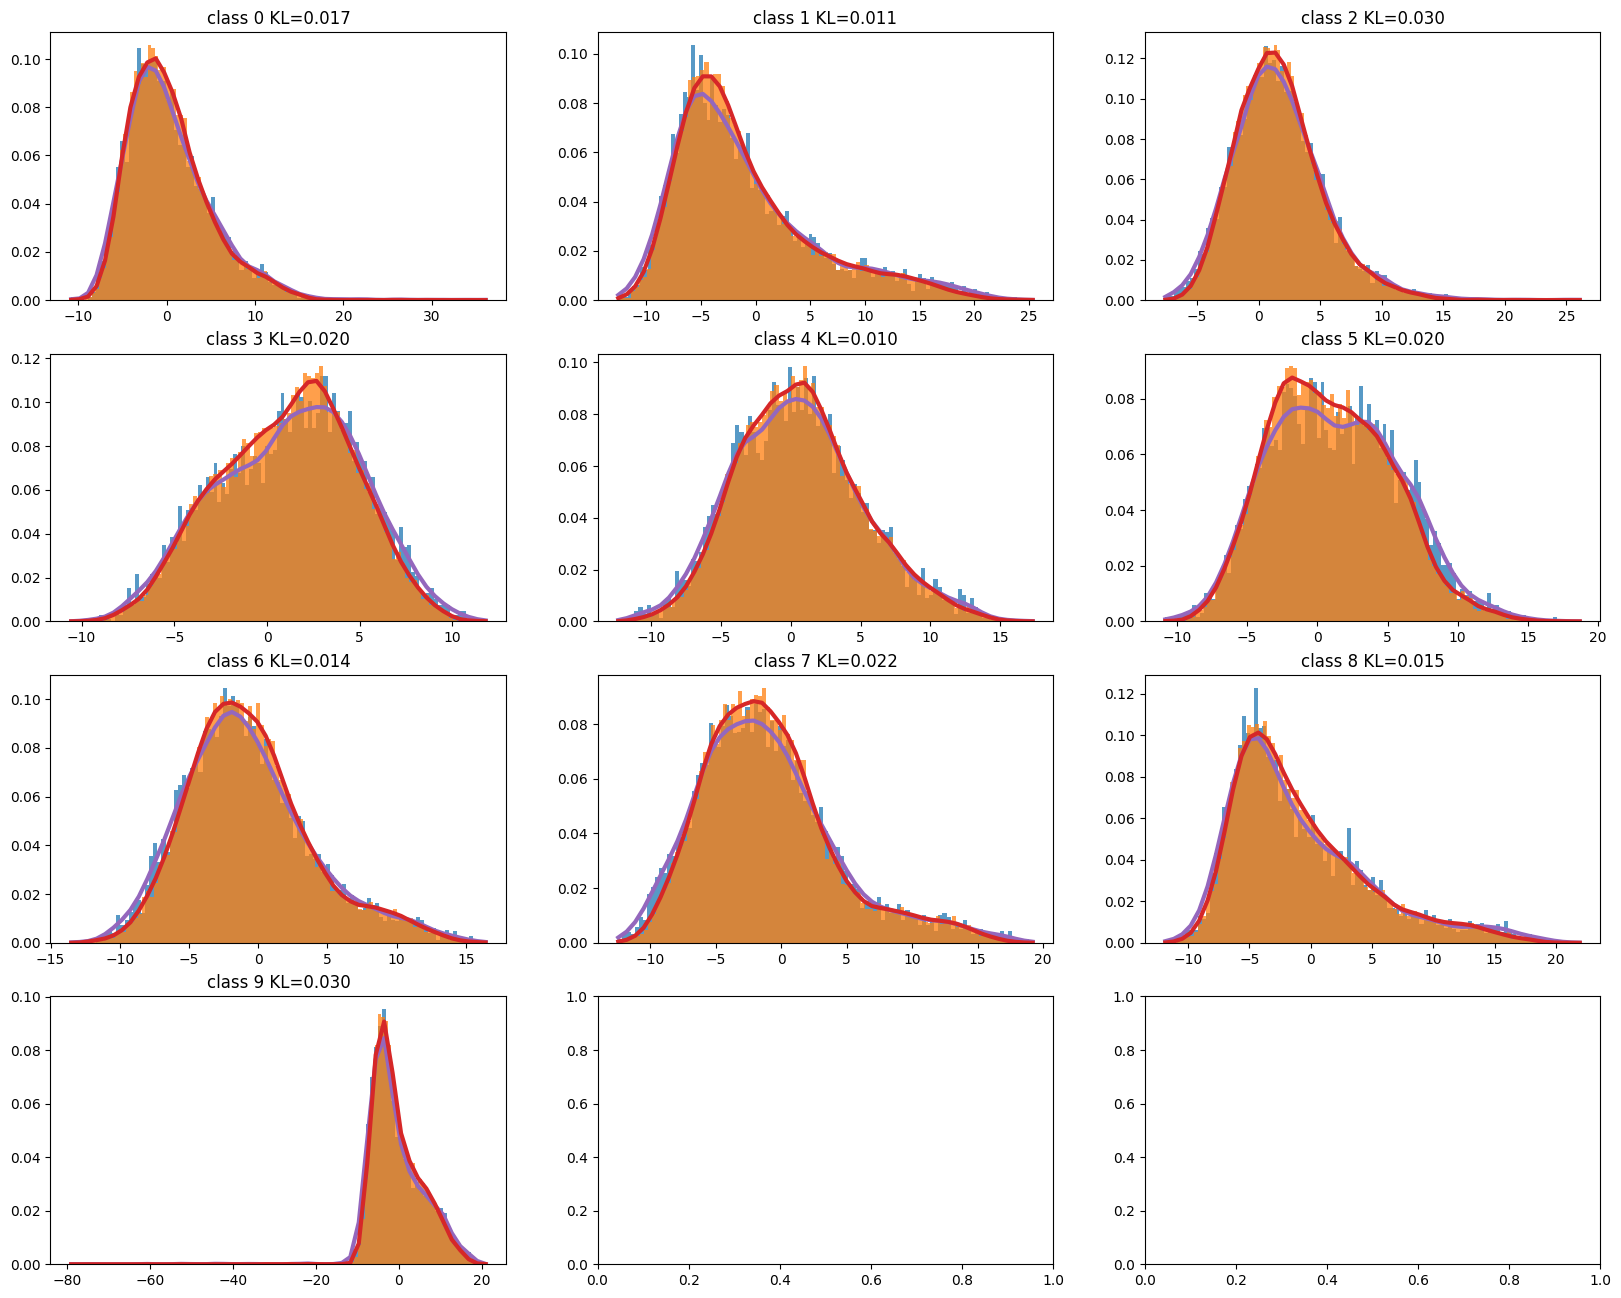

In [ ]:
JS_divergence(np.array(unseen_scores.logits.tolist()), np.array(retain_scores.logits.tolist()), plot=True)

0.007825287479202048

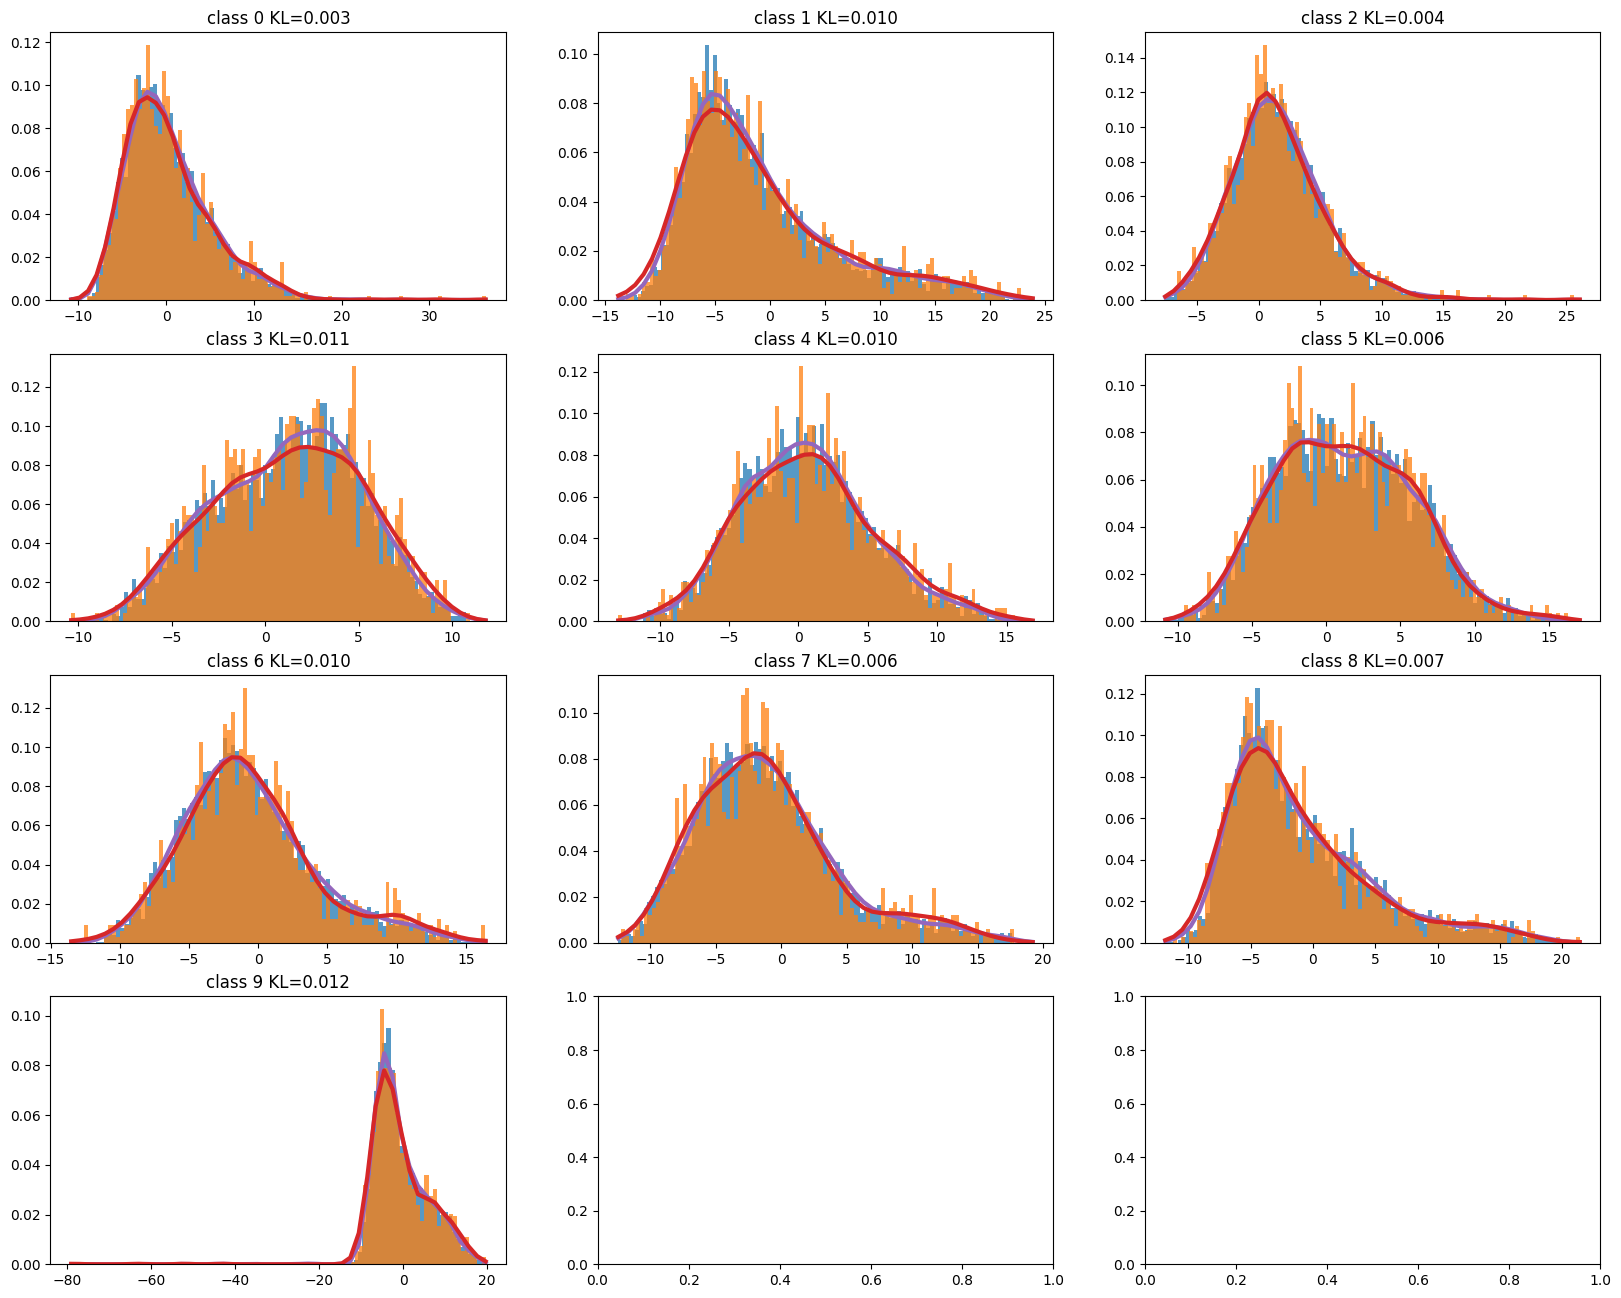

In [41]:
JS_divergence(np.array(unseen_scores.logits.tolist()), np.array(forget_scores.logits.tolist()), plot=True)

In [ ]:
trainer = Trainer(model)

In [ ]:
for p in trainer.discriminator.parameters():
    break

In [148]:
None > 1.2

TypeError: '>' not supported between instances of 'NoneType' and 'float'

In [ ]:
model.eval()
unseen_logits, unseen_labels = [], []

for u in tqdm(unseen, desc='score unseen', leave=False):
    unseen_logits.append(model(u[0].to(DEVICE)))
    unseen_labels.append(u[1].to(DEVICE))

unseen_logits = torch.cat(unseen_logits)
unseen_labels = torch.cat(unseen_labels)

In [ ]:
unseen_logits.requires_grad

True

In [ ]:
unseen_labels

tensor([0, 0, 0,  ..., 1, 1, 2], device='cuda:0')

In [114]:
hidden_size=128

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.class_embeddings = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(2*num_classes, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        
    def forward(self, logits, label):
        label_emb = self.class_embeddings(label)
        z = torch.hstack([logits, label_emb])
        return self.model(z).flatten()

class Trainer:
    def __init__(self, model):
        
        self.discriminator = Discriminator(10)
        self.model = model
        self.alpha = 1

        self.model.to(DEVICE)
        self.discriminator.to(DEVICE)
        
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, weight_decay=1e-5)
        self.d_criterion = nn.BCEWithLogitsLoss()

        self.g_optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-5, weight_decay=1e-5)
        self.g_criterion = nn.CrossEntropyLoss(reduction='mean')
        

    def generator_step(self, forget_logits, forget_labels, retain_logits, retain_labels):
        
        ones = torch.ones(forget_logits.size(0)).to(DEVICE)
        forget_preds = self.discriminator(forget_logits, forget_labels)
        d_loss = self.d_criterion(forget_preds, ones)
        
        g_loss = self.g_criterion(retain_logits, retain_labels)

        loss = d_loss + self.alpha * g_loss

        self.g_optimizer.zero_grad()
        loss.backward()
        self.g_optimizer.step()

        return loss.item()
        
    def discriminator_step(self, forget_logits, valid_logits, forget_labels, valid_labels):
        
        ones = torch.ones(valid_logits.size(0)).to(DEVICE)
        zeros = torch.zeros(forget_logits.size(0)).to(DEVICE)
    
        forget_preds = self.discriminator(forget_logits, forget_labels)
        valid_preds = self.discriminator(valid_logits, valid_labels)
        forget_loss = self.d_criterion(forget_preds, zeros)
        valid_loss = self.d_criterion(valid_preds, ones)
    
        loss = forget_loss + valid_loss
        self.d_optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.d_optimizer.step()

        return loss.item()
        
        
def gan_unlearning(model, retain, forget, valid):
    loss_path = PATH_TO_LOGS/'gan_loss.txt'
    metrics_path = PATH_TO_LOGS/'gan_metrics.txt'
    loss_path.write_text('step,D_loss,G_loss\n')
    metrics_path.write_text('step,forget_JS,valid_JS,forget_accuracy,valid_accuracy\n')
    
    trainer = Trainer(model)
    epochs = 30
    step = 0
    n_range = 10
    average_loss = None
    best_js = np.inf
    valid_scores = score_model(model, valid, progress=False)
    
    for epoch in range(epochs):
        
        for batch_idx, (forget_batch, retain_batch) in tqdm(enumerate(zip(forget, retain)), desc=f'epoch {epoch}/{epochs}', leave=False):
            
            step+= 1

            # discriminator step
            for i in range(n_range):
                trainer.model.eval()
                batch_inds = np.random.choice(len(valid_scores), size=BATCH_SIZE, replace=False)
                valid_logits = torch.tensor(valid_scores.loc[batch_inds, 'logits'].tolist(), device=DEVICE)
                valid_labels = torch.tensor(valid_scores.loc[batch_inds, 'labels'].tolist(), device=DEVICE)

                batch = next(iter(forget))
                forget_features = batch[0].to(DEVICE)
                forget_labels = batch[1].to(DEVICE)
                with torch.no_grad():
                    forget_logits = trainer.model(forget_features)

                d_loss = trainer.discriminator_step(forget_logits, valid_logits, forget_labels, valid_labels)
                average_loss = d_loss if average_loss is None else 0.9 * average_loss + 0.1 * d_loss
                if average_loss < 1.0:
                    n_range = max(n_range//2, 1)
                else:
                    n_range = 10
                        
            # generator step
            trainer.model.train()
            retain_features = retain_batch[0].to(DEVICE)
            retain_labels = retain_batch[1].to(DEVICE)
            retain_logits = trainer.model(retain_features)
            
            trainer.model.eval()
            forget_features = forget_batch[0].to(DEVICE)
            forget_labels = forget_batch[1].to(DEVICE)
            forget_logits = trainer.model(forget_features)
            
            g_loss = trainer.generator_step(forget_logits, forget_labels, retain_logits, retain_labels)

            with open(loss_path, 'a') as file:
                print(step, d_loss, g_loss, file=file, sep=',')
            if epoch > -1 and step % 20 == 0:
                fs = score_model(trainer.model, forget, progress=False)
                vs = score_model(trainer.model, valid, progress=False)
                f_js = JS_divergence_single(
                    fs.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
                    valid_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
                    plot=False)
                v_js = JS_divergence_single(
                    vs.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
                    valid_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
                    plot=False)
                af = accuracy_score(fs.labels, fs.preds)
                av = accuracy_score(vs.labels, vs.preds)
                
                if best_js > f_js:
                    best_js = f_js
                    best_model_state_dict = deepcopy(trainer.model.state_dict())
            
                with open(metrics_path, 'a') as file:
                    print(step, f_js, v_js, af, av, file=file, sep=',')

    trainer.model.load_state_dict(best_model_state_dict)
    trainer.model.eval()

In [115]:
dataset = Subset(cifar10, forget_inds)
forget = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

dataset = Subset(cifar10_aug, retain_inds)
retain = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

dataset = Subset(cifar10, unseen_inds)
unseen = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

In [116]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
gan_unlearning(model, retain, forget, unseen)

epoch 20/30: 2it [00:03,  1.95s/it]Traceback (most recent call last):
  File "/home/user/conda/envs/zhavoronkin_ungan/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/user/conda/envs/zhavoronkin_ungan/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/user/conda/envs/zhavoronkin_ungan/lib/python3.9/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/user/conda/envs/zhavoronkin_ungan/lib/python3.9/shutil.py", line 740, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/user/conda/envs/zhavoronkin_ungan/lib/python3.9/shutil.py", line 738, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-21mefa_3'


 [=======================================>]  Step: 4ms | Tot: 638ms | Acc: 86.35%%% Top2 Acc: 95.48% 84/84  
 [================================>.......]  Step: 3ms | Tot: 23ms | Acc: 83.38%%% Top2 Acc: 94.67% 5/5  
 [=======================================>]  Step: 3ms | Tot: 277ms | Acc: 73.46%%% Top2 Acc: 87.61% 40/40  
 [=======================================>]  Step: 3ms | Tot: 301ms | Acc: 73.46%%% Top2 Acc: 87.61% 40/40  
Shadow logits were brought from cache


100%|██████████| 88/88 [00:00<00:00, 120.14it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR
0,86.35,83.38,73.46,73.46,53.42,1.42


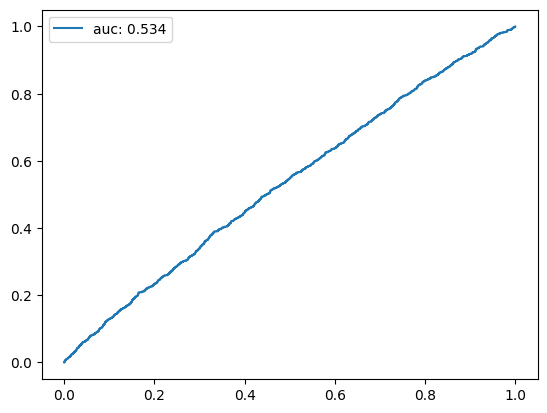

In [117]:
df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

In [ ]:
Unlearned = EasyDict()

In [ ]:
Unlearned.forget_scores = score_model(Unlearned.model, forget_dataloader)
Unlearned.valid_scores = score_model(Unlearned.model, valid_dataloader)
Unlearned.test_scores = score_model(Unlearned.model, test_dataloader)
Unlearned.retain_scores = score_model(Unlearned.model, retain_dataloader)


accuracy_score(Unlearned.forget_scores['labels'], Unlearned.forget_scores['preds']), \
accuracy_score(Unlearned.valid_scores['labels'], Unlearned.valid_scores['preds']), \
accuracy_score(Unlearned.test_scores['labels'], Unlearned.test_scores['preds']), \
accuracy_score(Unlearned.retain_scores['labels'], Unlearned.retain_scores['preds'])